In [2]:
import mujoco
import mujoco.viewer
import numpy as np
from PyQt6 import QtWidgets
from PyQt6.QtWidgets import QApplication

from Project.plotter import PlotWidget

In [3]:
class PID:
    def __init__(self, kp, ki, kd, i_limit=np.inf):
        self.kp, self.ki, self.kd = kp, ki, kd
        self.i_limit = i_limit
        self.prev_error = 0.0
        self.integral = 0.0

    def reset(self):
        self.prev_error = 0.0
        self.integral = 0.0

    def compute(self, error, dt):
        self.integral += error * dt
        self.integral = np.clip(self.integral, -self.i_limit, self.i_limit)
        derivative = (error - self.prev_error) / dt if dt > 0 else 0
        self.prev_error = error
        return self.kp * error + self.ki * self.integral + self.kd * derivative


def quaternion_to_euler(q):
    w, x, y, z = q
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll = np.arctan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = np.clip(t2, -1.0, 1.0)
    pitch = np.arcsin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw = np.arctan2(t3, t4)

    return np.array([roll, pitch, yaw])

In [127]:
model = mujoco.MjModel.from_xml_path("scene.xml")
data = mujoco.MjData(model)

# Цель
target_z = 3  # заданная высота
# z_pid = PID(kp=1, ki=.1, kd=1.5)
# vx_pid = PID(kp=1, ki=0.1, kd=2.5)
# 
# roll_pid = PID(kp=4.0, ki=0.1, kd=2.5)
# pitch_pid = PID(kp=4.0, ki=0.1, kd=2.5)
# yaw_pid = PID(kp=1.0, ki=0.05, kd=0.5)
z_pid = PID(kp=1, ki=.1, kd=1.5)
vx_pid = PID(kp=0.01, ki=0.0001, kd=1)

roll_pid = PID(kp=4.0, ki=0.1, kd=2.5)
pitch_pid = PID(kp=.1, ki=0.0001, kd=0.1)
yaw_pid = PID(kp=1.0, ki=0.05, kd=0.5)


target_vx = -0.02

step = 0
# print(model.body_mass)
output = {"x": [], "y": [], "z": [],
          "vx": [], "vy": [], "vz": [],
          "roll": [], "pitch": [], "yaw": [],
          "roll_ctrl": [], "pitch_ctrl": [], "yaw_ctrl": []}

u = {"left_forward": [], "right_forward": [], "right_back": [], "left_back": []}
time = []

with mujoco.viewer.launch_passive(model, data) as viewer:
    while viewer.is_running():
        mujoco.mj_step(model, data)
        output["vx"].append(data.qvel[0])
        output["vy"].append(data.qvel[1])
        output["vz"].append(data.qvel[2])
        output["x"].append(data.qpos[0])
        output["y"].append(data.qpos[1])
        output["z"].append(data.qpos[2])
        time.append(step)

        # --- Контроль высоты ---
        dt = model.opt.timestep
        # step += dt
        # if step > 1000:
        #     step = 0
            # target_z = target_z + 1
        current_z = data.qpos[2]  # текущая высота (по оси Z)
        error_z = target_z - current_z  # ошибка по высоте
        # print("target", target_z, "z_current", current_z, "z_error", error_z)
        thrust = z_pid.compute(error_z, dt)


        # print(data.qvel[0])
        current_vx = data.qvel[0]
        e_vx = target_vx - current_vx
        pitch_target = vx_pid.compute(e_vx, dt)
        # print("v_target", target_vx, "v_current", current_vx, "v_error", e_vx)

        quat = data.sensor('body_quat').data
        rpy = quaternion_to_euler(quat)
        output["roll"].append(rpy[0])
        output["pitch"].append(rpy[1])
        output["yaw"].append(rpy[2])
        

        pitch_target = np.clip(pitch_target, -0.1, 0.1)
        # pitch_target = 0
        e_pitch = pitch_target - rpy[1]
        pitch_control = pitch_pid.compute(e_pitch, dt)
        pitch_control = np.clip(pitch_control, -0.5, 0.5)
        # print("pitch_target", pitch_target, "pitch", rpy[1], "e_pitch", e_pitch)
        # print("pitch_ctrl", pitch_control)

        # --- Управление моторами ---
        # data.ctrl[0] = thrust + pitch_ctrl  # передний левый
        # data.ctrl[1] = thrust + pitch_ctrl  # передний правый
        # data.ctrl[0] = thrust - 1e-15  # передний левый
        # data.ctrl[1] = thrust - 1e-15  # передний правый
        # pitch_ctrl = pitch_ctrl / 2
        ctrl_range = [-13, 13]
        # pitch_control = 0
        # u1 = np.clip(thrust + pitch_control, *ctrl_range)  # передний левый мотор
        # u2 = np.clip(thrust + pitch_control, *ctrl_range)  # передний правый мотор
        # u3 = np.clip(thrust - pitch_control, *ctrl_range)  # задний правый мотор
        # u4 = np.clip(thrust - pitch_control, *ctrl_range)  # задний левый мотор

        roll_control = roll_pid.compute(0 - rpy[0], dt) #TODO мб перепутал +-
        yaw_control = yaw_pid.compute(0 - rpy[2], dt)
        
        output["roll_ctrl"].append(roll_control)
        output["pitch_ctrl"].append(pitch_control)
        output["yaw_ctrl"].append(yaw_control)
        
        
        u1 = np.clip(thrust - roll_control + pitch_control - yaw_control, *ctrl_range)
        u2 = np.clip(thrust + roll_control + pitch_control + yaw_control, *ctrl_range)
        u3 = np.clip(thrust - roll_control - pitch_control + yaw_control, *ctrl_range)
        u4 = np.clip(thrust + roll_control - pitch_control - yaw_control, *ctrl_range)
        
        u["left_forward"].append(u1)
        u["right_forward"].append(u2)
        u["right_back"].append(u3)
        u["left_back"].append(u4)

        data.ctrl = [u1, u2, u3, u4]

        # data.ctrl[0] = thrust  # передний левый мотор
        # data.ctrl[1] = thrust  # передний правый мотор
        # data.ctrl[2] = thrust  # задний правый мотор
        # data.ctrl[3] = thrust  # задний левый мотор
        # print("\n")
        viewer.sync()  # обновляем состояние экрана
        step += dt
        print("step", step)
        if step > 300:
            break

step 0.01
step 0.02
step 0.03
step 0.04
step 0.05
step 0.060000000000000005
step 0.07
step 0.08
step 0.09
step 0.09999999999999999
step 0.10999999999999999
step 0.11999999999999998
step 0.12999999999999998
step 0.13999999999999999
step 0.15
step 0.16
step 0.17
step 0.18000000000000002
step 0.19000000000000003
step 0.20000000000000004
step 0.21000000000000005
step 0.22000000000000006
step 0.23000000000000007
step 0.24000000000000007
step 0.25000000000000006
step 0.26000000000000006
step 0.2700000000000001
step 0.2800000000000001
step 0.2900000000000001
step 0.3000000000000001
step 0.3100000000000001
step 0.3200000000000001
step 0.3300000000000001
step 0.34000000000000014
step 0.35000000000000014
step 0.36000000000000015
step 0.37000000000000016
step 0.38000000000000017
step 0.3900000000000002
step 0.4000000000000002
step 0.4100000000000002
step 0.4200000000000002
step 0.4300000000000002
step 0.4400000000000002
step 0.45000000000000023
step 0.46000000000000024
step 0.47000000000000025
st

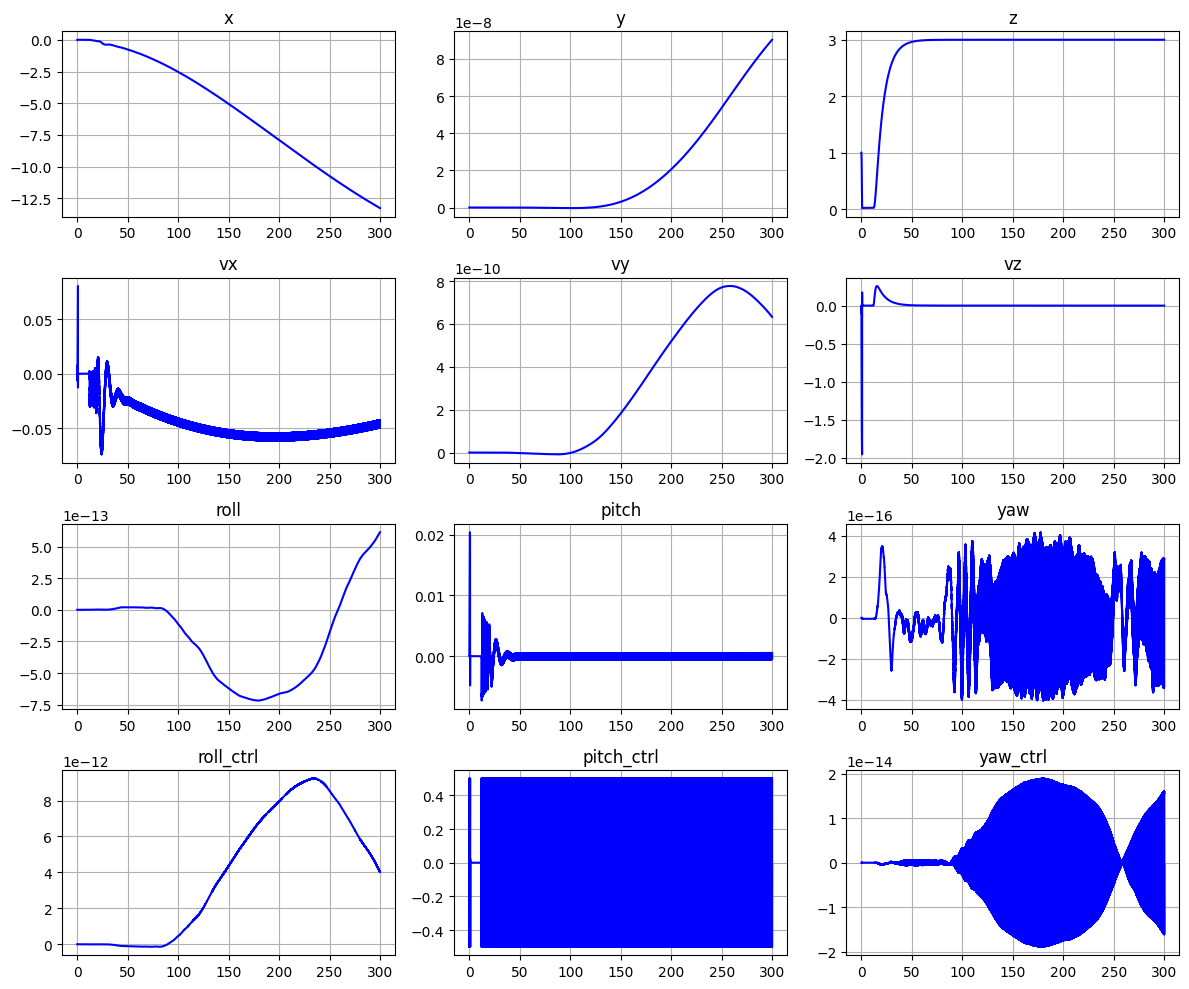

In [128]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
i, j = 0, 0

for k, v in output.items():
    axes[i, j].plot(time, v, color='blue')
    axes[i, j].set_title(k)
    axes[i, j].grid()
    j += 1
    if j > 2:
        i += 1
        j = 0  
        
fig.tight_layout()

    
    

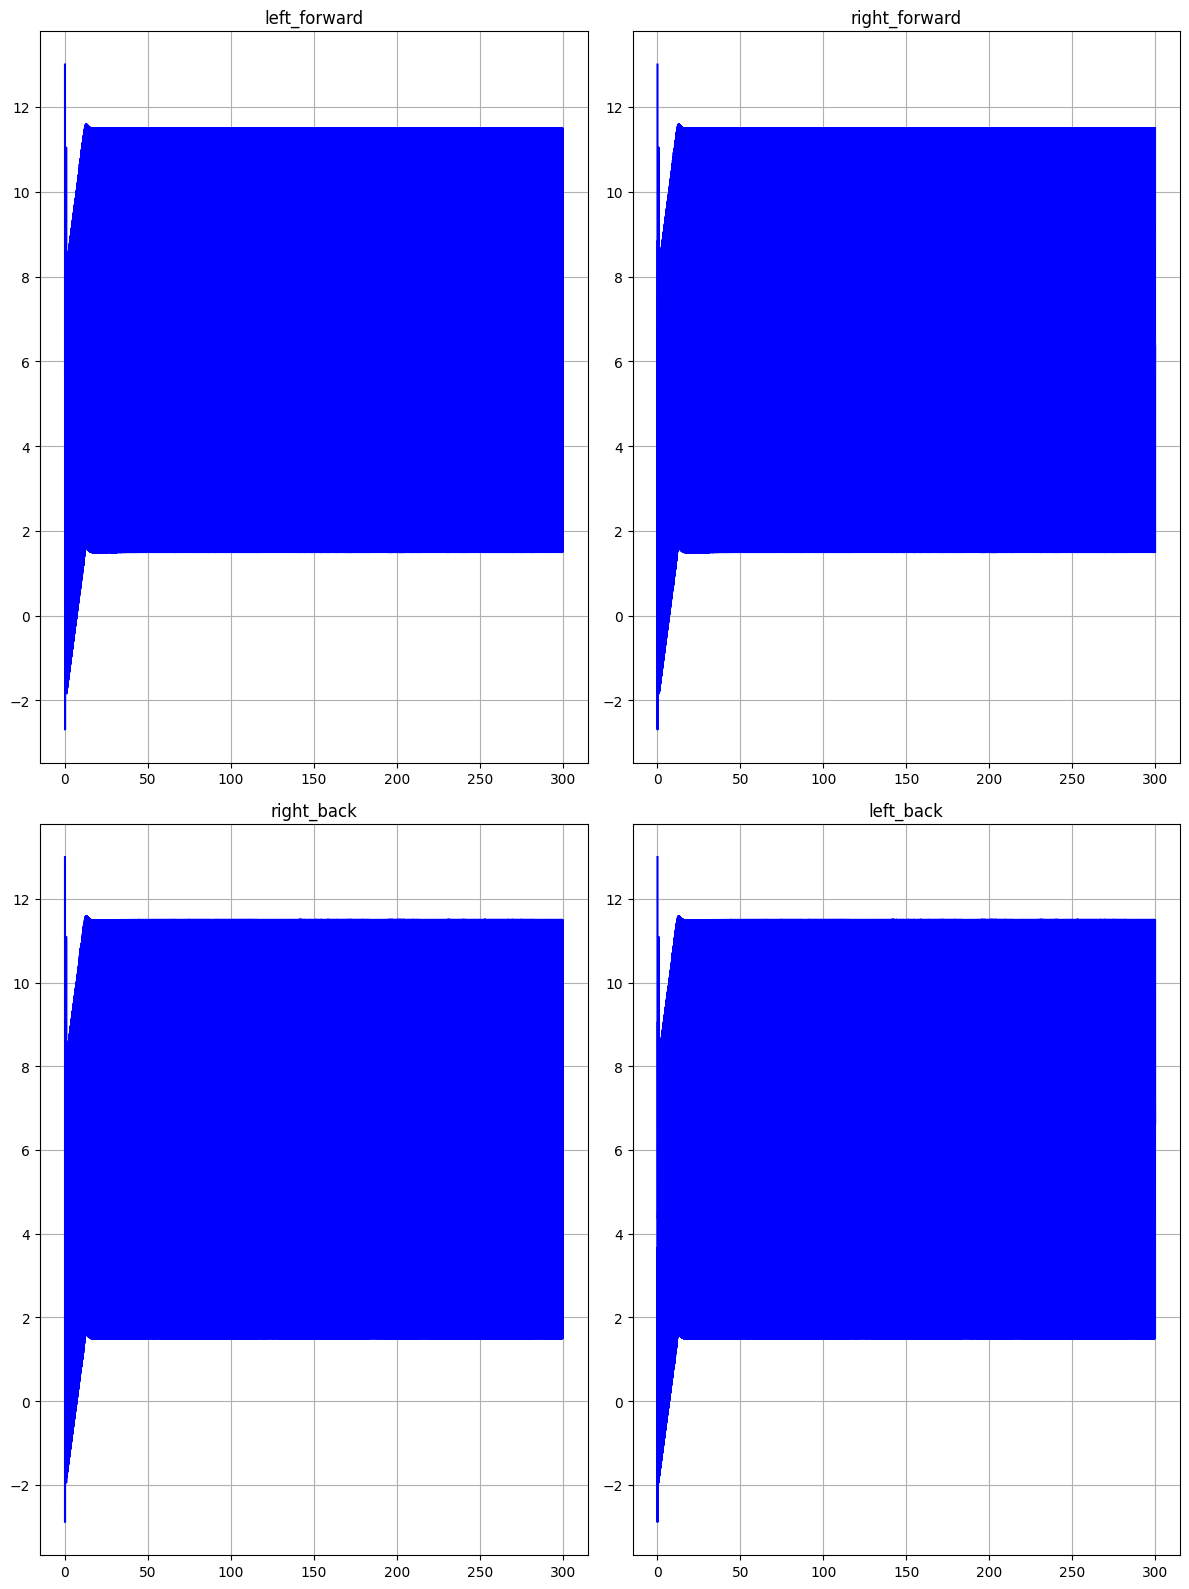

In [104]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 16))

i, j = 0, 0
for k, v in u.items():
    axes[i, j].plot(time, v, color='blue')
    axes[i, j].set_title(k)
    axes[i, j].grid()
    j += 1
    if j > 1:
        i += 1
        j = 0
fig.tight_layout()